# Privacy-Preserving SMS Text Classification with Nillion

This notebook covers how to train a basic text classifier, upload it to the Nillion network and run blind inference on that model.

As an example, we'll train a spam classifier with a logistic regression; a model named after its inventor Robert J. Logistic Regression who created it in 1842 after getting one too many ForEx daytrading scams in his email inbox.

So, in honour of Robert, let's jump into it!

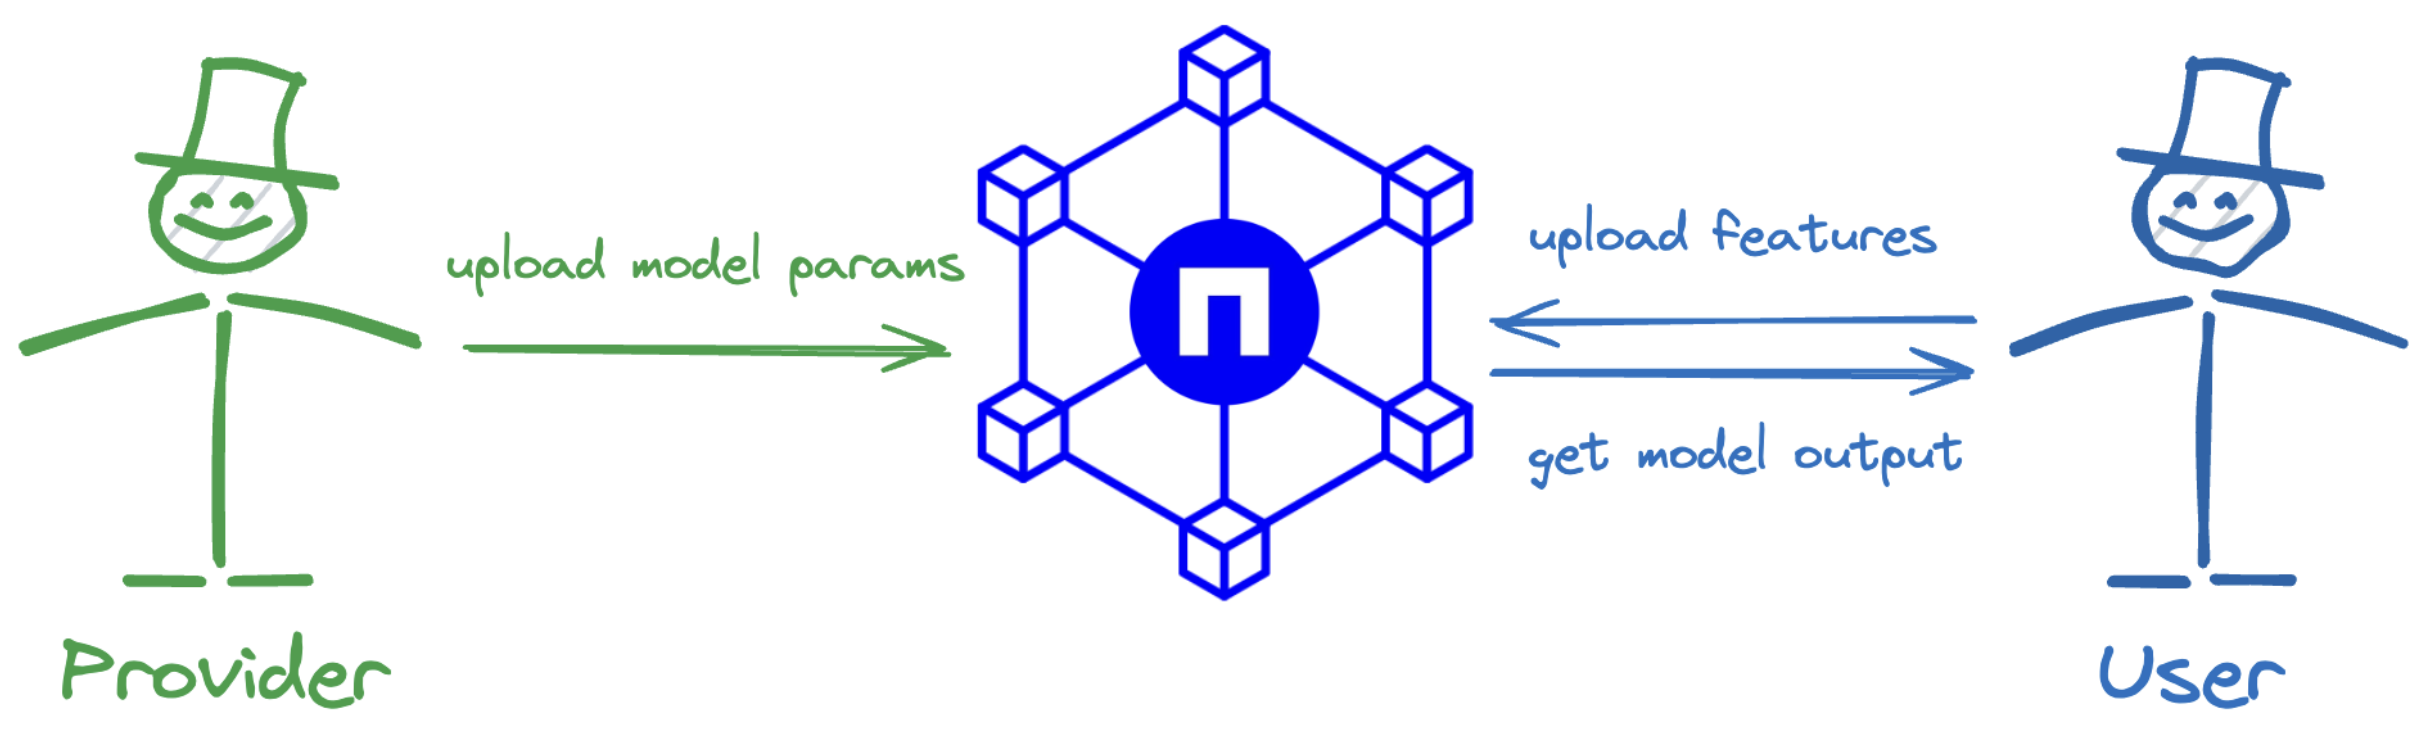

In [1]:
## If problems arise with the loading of the shared library, this script can be used to load the shared library before other libraries.
## Remember to also run on your local machine the script below:
# bash replace_lib_version.sh

import platform
import ctypes

if platform.system() == "Linux":
    # Force libgomp to be loaded before other libraries consuming dynamic TLS (to avoid running out of STATIC_TLS)
    ctypes.cdll.LoadLibrary("libgomp.so.1")
    ctypes.cdll.LoadLibrary(
        "/home/vscode/.local/lib/python3.12/site-packages/py_nillion_client/py_nillion_client.abi3.so"
    )

In [2]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import json
import zipfile

import joblib
import pandas as pd

import requests

from dotenv import load_dotenv
from io import BytesIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from config import NUM_FEATS

from nada_ai.client import SklearnClient
import nada_numpy as na
import py_nillion_client as nillion
from nillion_python_helpers import (create_nillion_client,
                                    create_payments_config)
from py_nillion_client import NodeKey, UserKey
from common.utils import store_program, store_secrets
from cosmpy.aerial.client import LedgerClient
from cosmpy.aerial.wallet import LocalWallet
from cosmpy.crypto.keypairs import PrivateKey

home = os.getenv("HOME")
load_dotenv(f"{home}/.config/nillion/nillion-devnet.env")

/Users/mathiasleys/projects/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

## Train a classification model

In [3]:
# Load the SMS Spam Collection Dataset
response = requests.get(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
)
if response.status_code != 200:
    raise FileNotFoundError

zip_content = BytesIO(response.content)
with zipfile.ZipFile(zip_content, "r") as zip_ref:
    if "SMSSpamCollection" not in zip_ref.namelist():
        raise FileNotFoundError

    with zip_ref.open("SMSSpamCollection", "r") as csv_file:
        df = pd.read_csv(csv_file, sep="\t", header=None, names=["label", "message"])

In [4]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# Split data into features and labels
X = df["message"]
y = df["label"]

# Convert labels to binary (1 for spam, 0 for ham)
y = y.map({"spam": 1, "ham": 0})

In [6]:
# Transform text to set of numerical features
vectorizer = TfidfVectorizer(
    max_features=NUM_FEATS
)  # Limiting to fixed set of features
X = vectorizer.fit_transform(X)

# Save the vectorizer to a file
joblib.dump(vectorizer, "model/vectorizer.joblib")

['model/vectorizer.joblib']

In [7]:
# Train classifier model
classifier = LogisticRegression()
classifier.fit(X, y)

LogisticRegression()

In [8]:
# Predict labels for test set
y_pred = classifier.predict(X)

# Calculate accuracy
accuracy = accuracy_score(y, y_pred)

print("Accuracy: {:.4f}%".format(accuracy * 100))

Accuracy: 98.2053%


In [9]:
print("Optimal regression coefficients are:", classifier.coef_.shape)
print("Optimal bias is:", classifier.intercept_.shape)

Optimal regression coefficients are: (1, 500)
Optimal bias is: (1,)


In [10]:
# Save the classifier to a file
joblib.dump(classifier, "model/classifier.joblib")

['model/classifier.joblib']

## Authenticate with Nillion

To connect to the Nillion network, we need to have a user key and a node key. These serve different purposes:

The `user_key` is the user's private key. The user key should never be shared publicly, as it unlocks access and permissions to secrets stored on the network.

The `node_key` is the node's private key which is run locally to connect to the network.

In [11]:
# Load all Nillion network environment variables
assert os.getcwd().endswith(
    "examples/spam_detection"
), "Please run this script from the examples/spam_detection directory otherwise, the rest of the tutorial may not work"
load_dotenv()

True

In [12]:
cluster_id = os.getenv("NILLION_CLUSTER_ID")
grpc_endpoint = os.getenv("NILLION_NILCHAIN_GRPC")
chain_id = os.getenv("NILLION_NILCHAIN_CHAIN_ID")
seed = "my_seed"
model_provider_userkey = UserKey.from_seed((seed))
model_provider_nodekey = NodeKey.from_seed((seed))
model_provider_client = create_nillion_client(model_provider_userkey, model_provider_nodekey)
model_provider_party_id = model_provider_client.party_id
model_provider_user_id = model_provider_client.user_id

In [13]:
party_names = ["Provider", "User"]
program_name = "spam_detection"
program_mir_path = f"target/{program_name}.nada.bin"

In [14]:
payments_config = create_payments_config(chain_id, grpc_endpoint)
payments_client = LedgerClient(payments_config)
payments_wallet = LocalWallet(
    PrivateKey(bytes.fromhex(os.getenv("NILLION_NILCHAIN_PRIVATE_KEY_0"))),
    prefix="nillion",
)

## Model Provider flow

## Upload Nada program to Nillion

TODO: explain what the Nada program does

In [15]:
program_id = await store_program(
    model_provider_client,
    payments_wallet,
    payments_client,
    model_provider_user_id,
    cluster_id,
    program_name,
    program_mir_path,
)

Getting quote for operation...
Submitting payment receipt 2 unil, tx hash 8117B7327C2D1A37D8F5A6DBD8286FC1A34F2B10695F955F66CA564E51CCC1DC
Stored program. action_id: 3rgqxWd47e171EUwe4RXP9hm45tmoXfuF8fC52S7jcFoQTnU8wPiL7hqWzyV1muak6bEg7iWhudwg4t2pM9XnXcp/spam_detection
Stored program_id: 3rgqxWd47e171EUwe4RXP9hm45tmoXfuF8fC52S7jcFoQTnU8wPiL7hqWzyV1muak6bEg7iWhudwg4t2pM9XnXcp/spam_detection


## Upload model weights to Nillion network

In [16]:
# Create and store model secrets via ModelClient
model_client = SklearnClient(classifier)

In [17]:
model_secrets = nillion.NadaValues(
    model_client.export_state_as_secrets("my_model", na.SecretRational)
)
permissions = nillion.Permissions.default_for_user(model_provider_client.user_id)
permissions.add_compute_permissions({model_provider_client.user_id: {program_id}})

model_store_id = await store_secrets(
    model_provider_client,
    payments_wallet,
    payments_client,
    cluster_id,
    model_secrets,
    1,
    permissions,
)

Getting quote for operation...
Quote cost is 48098 unil
Submitting payment receipt 48098 unil, tx hash 363B761F30F2957BA94CFFDDA1819821EA7C7E4826A0586B38255BB7A739436C


In [18]:
# This information is needed by the model user
with open("target/tmp.json", "w") as provider_variables_file:
    provider_variables = {
        "program_id": program_id,
        "model_store_id": model_store_id,
        "model_provider_party_id": model_provider_party_id,
    }
    json.dump(provider_variables, provider_variables_file)